In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import math
import os
import random
import torch
import warnings
warnings.filterwarnings('ignore')

In [2]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# 自 Yahoo Finance 下載資料

In [3]:
#yahoo finance有六個欄位，Open High Low Close Adjusted-Close Volume
def get_historical_Data(ticker, start, end):
    start_date = datetime.strptime(start, '%Y-%m-%d')
    end_date = datetime.strptime(end, '%Y-%m-%d')
    data = pd.DataFrame()
    for j in range(6):
        data = pd.concat([data, pd.DataFrame(yf.download(ticker, start=start_date, 
                                                         end=end_date).iloc[:, j])], axis=1)

    return data

In [4]:
df = get_historical_Data('SPY', '1993-01-01', '2022-12-31')
df.head(10)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,25.122335,1003200
1993-02-01,43.96875,44.25000,43.96875,44.25000,25.301027,480500
1993-02-02,44.21875,44.37500,44.12500,44.34375,25.354633,201300
1993-02-03,44.40625,44.84375,44.37500,44.81250,25.622643,529400
1993-02-04,44.96875,45.09375,44.46875,45.00000,25.729839,531500
1993-02-05,44.96875,45.06250,44.71875,44.96875,25.711979,492100
1993-02-08,44.96875,45.12500,44.90625,44.96875,25.711979,596100
1993-02-09,44.81250,44.81250,44.56250,44.65625,25.533312,122100
1993-02-10,44.65625,44.75000,44.53125,44.71875,25.569033,379600


In [5]:
#只留收盤、volume 試試看 IQR、用OHLC算variation、保留tensor結構
#多資產、多個 Sector、用Naive方法預測

In [6]:
df['log_hl'] = np.log(df['High'] / df['Low'])
df['log_co'] = np.log(df['Close'] / df['Open'])
df['Adj_Close_pct_change'] = df['Adj Close'].pct_change()
df['log_volume'] = np.log(df['Volume'])
data = df[['Adj_Close_pct_change', 'log_volume', 'log_co', 'log_hl']]
data.dropna(inplace = True)
data

,Adj_Close_pct_change,log_volume,log_co,log_hl
Date,,,,
1993-02-01,0.007113,13.082583,0.006376,0.006376
1993-02-02,0.002119,12.212552,0.002823,0.005650
1993-02-03,0.010570,13.179500,0.009107,0.010508
1993-02-04,0.004184,13.183458,0.000695,0.013957
1993-02-05,-0.000694,13.106437,0.000000,0.007658
...,...,...,...,...
2022-12-23,0.005752,17.907474,0.008550,0.013218
2022-12-27,-0.003944,17.759772,-0.003638,0.009177
2022-12-28,-0.012428,18.076943,-0.012322,0.018347


# DataFrame to Torch

In [7]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device = {device}")

Device = cpu


In [8]:
Features = torch.tensor(data.values)
Lable = torch.tensor(data['Adj_Close_pct_change'].values)

#Build rolling window of the features using unfold+flatten
X = Features.unfold(0, 10, 1)[:-1].to(torch.float32).to(device)# [:-1] is to drop the last row
y = Lable[10:].to(torch.float32).to(device)

print(f'Shape of the Features: {X.shape}, Shape of the Labels: {y.shape}')

Shape of the Features: torch.Size([7525, 4, 10]), Shape of the Labels: torch.Size([7525])


In [9]:
X[0]

tensor([[ 7.1129e-03,  2.1187e-03,  1.0570e-02,  4.1837e-03, -6.9415e-04,
          0.0000e+00, -6.9488e-03,  1.3990e-03,  4.8918e-03, -7.6485e-03],
        [ 1.3083e+01,  1.2213e+01,  1.3179e+01,  1.3183e+01,  1.3106e+01,
          1.3298e+01,  1.1713e+01,  1.2847e+01,  9.8782e+00,  1.0657e+01],
        [ 6.3762e-03,  2.8229e-03,  9.1069e-03,  6.9469e-04,  0.0000e+00,
          0.0000e+00, -3.4928e-03,  1.3986e-03,  3.4831e-03, -6.2871e-03],
        [ 6.3762e-03,  5.6497e-03,  1.0508e-02,  1.3957e-02,  7.6575e-03,
          4.8594e-03,  5.5944e-03,  4.9003e-03,  7.6469e-03,  6.2871e-03]])

In [10]:
y[0]

tensor(-0.0252)

# Split Data

In [11]:
X.shape, y.shape

(torch.Size([7525, 4, 10]), torch.Size([7525]))

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_rem, y_train, y_rem = train_test_split(X, y, 
                                                  test_size=0.3,
                                                  shuffle = False)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, 
                                                    test_size=0.5,
                                                    shuffle = False)

len(X_train), len(X_valid),len(X_test), len(y_train), len(y_valid), len(y_test)

(5267, 1129, 1129, 5267, 1129, 1129)

# Data Loader

In [13]:
from torch.utils.data import TensorDataset, DataLoader

#Put Features and Labels Together
train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

# Setup the batch size hyperparameter
BATCH_SIZE = 64
# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=False # shuffle data every epoch?
)

valid_dataloader = DataLoader(valid_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [14]:
#Check the first batch in our training data
first_batch = next(iter(train_dataloader))[0]

first_batch, first_batch.shape

(tensor([[[ 7.1129e-03,  2.1187e-03,  1.0570e-02,  ...,  1.3990e-03,
            4.8918e-03, -7.6485e-03],
          [ 1.3083e+01,  1.2213e+01,  1.3179e+01,  ...,  1.2847e+01,
            9.8782e+00,  1.0657e+01],
          [ 6.3762e-03,  2.8229e-03,  9.1069e-03,  ...,  1.3986e-03,
            3.4831e-03, -6.2871e-03],
          [ 6.3762e-03,  5.6497e-03,  1.0508e-02,  ...,  4.9003e-03,
            7.6469e-03,  6.2871e-03]],
 
         [[ 2.1187e-03,  1.0570e-02,  4.1837e-03,  ...,  4.8918e-03,
           -7.6485e-03, -2.5228e-02],
          [ 1.2213e+01,  1.3179e+01,  1.3183e+01,  ...,  9.8782e+00,
            1.0657e+01,  1.2834e+01],
          [ 2.8229e-03,  9.1069e-03,  6.9469e-04,  ...,  3.4831e-03,
           -6.2871e-03, -2.2744e-02],
          [ 5.6497e-03,  1.0508e-02,  1.3957e-02,  ...,  7.6469e-03,
            6.2871e-03,  2.4183e-02]],
 
         [[ 1.0570e-02,  4.1837e-03, -6.9415e-04,  ..., -7.6485e-03,
           -2.5228e-02, -7.1845e-04],
          [ 1.3179e+01,  1.3183

# Build a Smaller Model

In [47]:
import torch.nn as nn

class GetLSTMOutput(nn.Module): #To Ignore the second output of LSTM Layer
    def forward(self, x):
        out, _ = x
        return out
    
class newmodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.BatchNorm1d(num_features = 4),
            nn.Conv1d(in_channels=4, out_channels=16, kernel_size=3),
            nn.MaxPool1d(kernel_size = 2),
            nn.ReLU(),
            nn.Flatten(),
            nn.LSTM(input_size=64, hidden_size=16, bidirectional=True, batch_first=True),
            GetLSTMOutput(),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Dropout(p = 0.1)
        )
        
    def forward(self, x):
        x = self.layers(x) #pass through CNN Layers
        return x.squeeze()

In [48]:
from torchinfo import summary
summary(newmodel(), input_size=[64, 4, 10]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
newmodel                                 [64]                      --
├─Sequential: 1-1                        [64, 1]                   --
│    └─BatchNorm1d: 2-1                  [64, 4, 10]               8
│    └─Conv1d: 2-2                       [64, 16, 8]               208
│    └─MaxPool1d: 2-3                    [64, 16, 4]               --
│    └─ReLU: 2-4                         [64, 16, 4]               --
│    └─Flatten: 2-5                      [64, 64]                  --
│    └─LSTM: 2-6                         [64, 32]                  10,496
│    └─GetLSTMOutput: 2-7                [64, 32]                  --
│    └─ReLU: 2-8                         [64, 32]                  --
│    └─Linear: 2-9                       [64, 1]                   33
│    └─Dropout: 2-10                     [64, 1]                   --
Total params: 10,745
Trainable params: 10,745
Non-trainable params: 0
Total mult-

# Training Loop, Loss Function and Optimizer

In [49]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [55]:
torch.manual_seed(seed)
model = newmodel().to(device)
loss_fn = nn.HuberLoss(reduction = 'mean', delta = 1.0) #The Loss Function to train model
mse_loss = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.01)

from tqdm.auto import tqdm
train_time_start_on_cpu = timer()

epochs = 100

best_loss = math.inf

if not os.path.isdir('./models'):
    os.mkdir('./models') # Create directory of saving models.
    
model_save_path = './models/SmallCNNBiLSTMmodel.ckpt'

# Create training and validating loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    train_mse = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model.train() 
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch
        train_mse += mse_loss(y_pred, y)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 40 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    train_mse /= len(train_dataloader)
    
    ### Validating
    # Setup variables for accumulatively adding up loss and accuracy 
    valid_loss = 0 
    valid_mse = 0
    model.eval()
    with torch.inference_mode():
        for X, y in valid_dataloader:
            # 1. Forward pass
            valid_pred = model(X)
           
            # 2. Calculate loss (accumatively)
            valid_loss += loss_fn(valid_pred, y) # accumulatively add up the loss per epoch
            valid_mse += mse_loss(valid_pred, y)
        
        # Calculations on valid metrics need to happen inside torch.inference_mode()
        # Divide total valid loss by length of valid dataloader (per batch)
        valid_loss /= len(valid_dataloader)
        valid_mse /= len(valid_dataloader)

        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), model_save_path) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.7f} | Train mse: {train_mse:.7f} | Valid loss: {valid_loss:.7f} | Valid mse: {valid_mse:.7f}")

# Calculate training time      
train_time_end_on_cpu = timer()
total_train_time_model = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model.parameters()).device))

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/5267 samples
Looked at 2560/5267 samples
Looked at 5120/5267 samples
Saving model with loss 0.000...

Train loss: 0.0085400 | Train mse: 0.0170947 | Valid loss: 0.0000644 | Valid mse: 0.0001288
Epoch: 1
-------
Looked at 0/5267 samples
Looked at 2560/5267 samples
Looked at 5120/5267 samples

Train loss: 0.0001093 | Train mse: 0.0002185 | Valid loss: 0.0000702 | Valid mse: 0.0001404
Epoch: 2
-------
Looked at 0/5267 samples
Looked at 2560/5267 samples
Looked at 5120/5267 samples

Train loss: 0.0001009 | Train mse: 0.0002017 | Valid loss: 0.0000997 | Valid mse: 0.0001993
Epoch: 3
-------
Looked at 0/5267 samples
Looked at 2560/5267 samples
Looked at 5120/5267 samples

Train loss: 0.0001635 | Train mse: 0.0003270 | Valid loss: 0.0002430 | Valid mse: 0.0004859
Epoch: 4
-------
Looked at 0/5267 samples
Looked at 2560/5267 samples
Looked at 5120/5267 samples
Saving model with loss 0.000...

Train loss: 0.0002150 | Train mse: 0.0004300 | Valid loss: 0.0000535 | Va

# Test Set

In [56]:
#Load Trained Model
model_test = newmodel().to(device)
model_test.load_state_dict(torch.load(model_save_path))

model_test.eval()
with torch.inference_mode():
    test_pred = model_test(X_test)
    print(f'The MSE Loss on Test Set is: {mse_loss(test_pred, y_test):.7f}')

The MSE Loss on Test Set is: 0.0000707


In [57]:
pd.DataFrame(test_pred).rename(columns = {0 : 'pred'})
pd.DataFrame(y_test).rename(columns = {0 : 'real'})
df = pd.concat([pd.DataFrame(test_pred).rename(columns = {0 : 'pred'}),
                pd.DataFrame(y_test).rename(columns = {0 : 'real'})],
                axis = 1)
df.index = data[-1129:].index

print(f'The correlation between real and predicted return is: {df.corr().iloc[0,1]}.')
print(f'From {df.index[0].date()} to {df.index[-1].date()}')

The correlation between real and predicted return is: 0.8227534297464076.
From 2018-07-10 to 2022-12-30


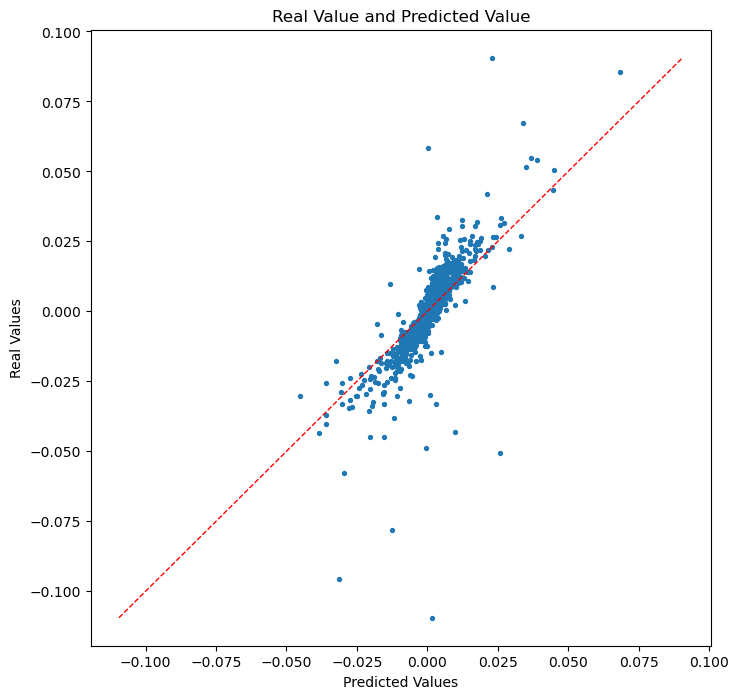

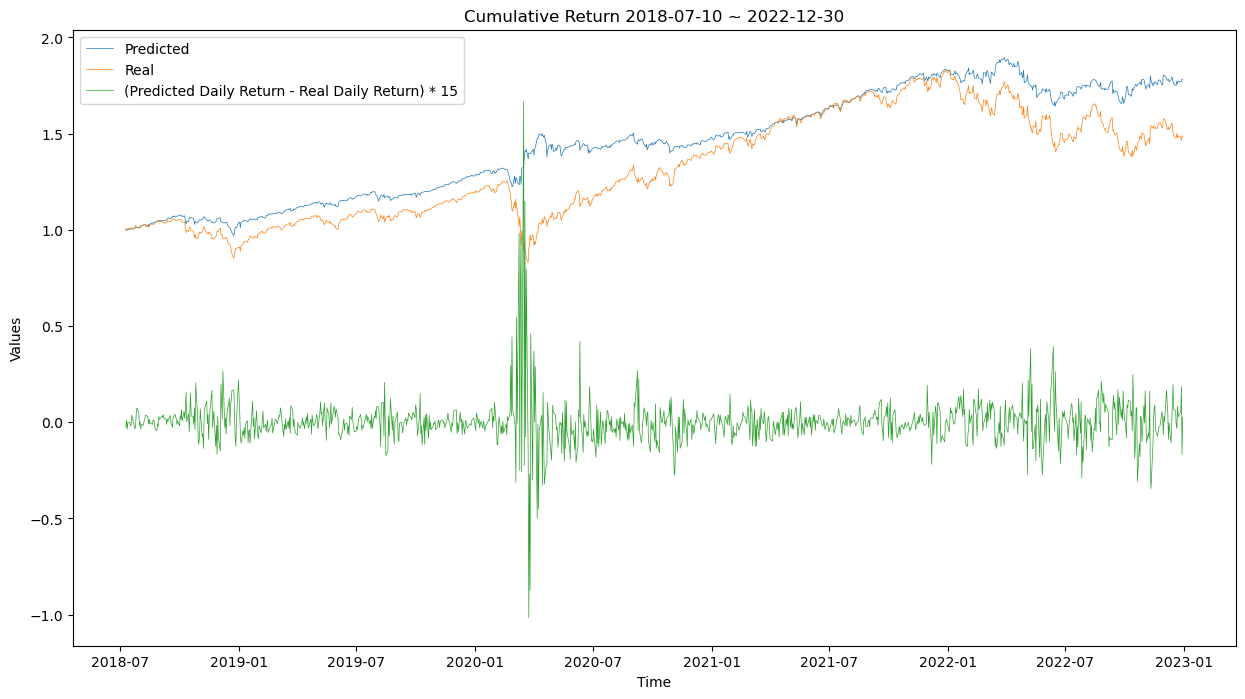

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
pred = df['pred'].values
real = df['real'].values
plt.scatter(pred, real, s=8)
# Add 45 degree line
x = np.linspace(min(pred.min(), real.min()), max(pred.max(), real.max()), 100)
plt.plot(x, x, color='red', linestyle='--', linewidth=1)
# Add labels and title
plt.xlabel('Predicted Values')
plt.ylabel('Real Values')
plt.title('Real Value and Predicted Value')
##########################################################################################################################################
plt.figure(figsize=(15, 8))
plt.plot(df.index, (1+ df['pred']).cumprod(), label='Predicted', linewidth=0.5)
plt.plot(df.index, (1+ df['real']).cumprod(), label='Real', linewidth=0.5)
plt.plot(df.index, 15*(df['pred'] - df['real']), label='(Predicted Daily Return - Real Daily Return) * 15', linewidth=0.5)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Cumulative Return 2018-07-10 ~ 2022-12-30')
plt.show()